# GANs and Variational Autoencoders

GANs and VAEs. We train the generator to produce samples form a posterior density with unknown analytic form. See paper.

In [1]:
#%matplotlib inline
from matplotlib import pylab as plt
import numpy as np
from scipy.stats import multivariate_normal as mn
from scipy.stats import expon
import tensorflow as tf
from numpy.random import choice as sample


In [2]:
#Auxiliary functions
np.random.seed(seed=1234)
def plot_fig(x, M, zmin = -5, zmax = 5, cmap_par = 'Greys'):
    #Unnormalised posteior plot:
    zPost = postDist(x, priorDist = zPrior)

    countour_plot(zPost, zmin, zmax, cmap_par = cmap_par)

    # distribution of inverse-mapped points
    noise = mn(mean = [0,0,0], cov = np.eye(3)).rvs(size = M)
    x_vec = np.reshape(np.repeat(x, M), (M,1))
    x_g = sess.run(G, {gen_noise_node:noise,  gen_x_node: x_vec})
    plt.scatter(x_g[:,0], x_g[:,1],label='p_g', alpha = 0.3)
    #plt.title('Unnormalised posterior density for x = ' + str(x))

def countour_plot(dataDist, range_min = -1, range_max = 3, delta = 0.025, label = False, cmap_par = 'Greys'):
    x = y = np.arange(range_min, range_max, delta)
    X, Y = np.meshgrid(x, y)
    Z = X.copy()
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = dataDist.pdf(np.array([X[i,j],Y[i,j]]))
    plt.figure()
    CS = plt.contour(X, Y, Z, cmap = cmap_par)
    if label == True:
        plt.clabel(CS, inline=1, fontsize=10)

#Optimizer
def adam_optimizer(loss, var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        learning_rate = 0.001,
        global_step = batch,
        decay_steps = 250,
        decay_rate = 0.95,
        staircase=True
    )
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss,global_step=batch,var_list=var_list)
    return optimizer



In [3]:
#Parameter of exponential density as function 2-dim latent vector.
class postDist(object):
    def __init__(self, x, priorDist):
        self.x = x
        self.priorDist = priorDist
    def beta_par(self, z):
        beta = 1 + (np.array(z)**2).sum(axis=0)
        return beta
    def logLik(self, z):
        return -np.log(self.beta_par(z.T)) - self.x/self.beta_par(z.T)
    def pdf(self, z): # Unnormalised posterior density.
        post_pdf = np.exp(self.logLik(z)+self.priorDist.logpdf(z))
        return post_pdf


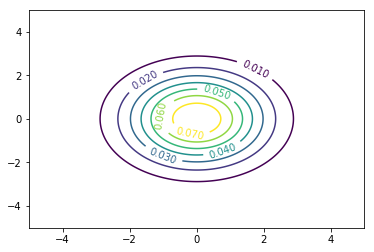

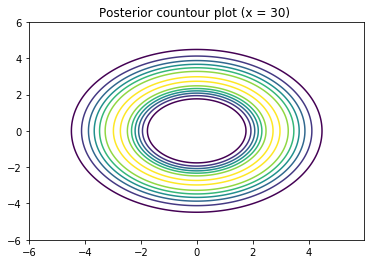

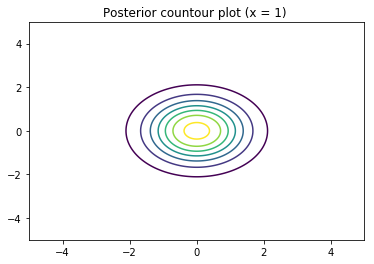

In [5]:
#create a regular grid in weight space for visualisation
np.random.seed(seed=1234)
zmin = -5
zmax = 5

prior_var = 2
zPrior = mn([0,0], np.eye(2)*prior_var)
#let the likelihood be a simple exponential distribution where the
#mean is parametrised by the two hidden variables x_1 and x_2
zPost = postDist(x = 30, priorDist = zPrior)
zPost1 = postDist(x = 1, priorDist = zPrior)
#Prior and Posterior contour plot:
countour_plot(zPrior, zmin, zmax, label  = True, cmap_par = 'viridis')
#plt.title('Prior countour plot')
plt.savefig('../thesis/images/prior_contour.png')
#Unnormalised posteior plot:
countour_plot(zPost, zmin-1, zmax+1, label = False, cmap_par = 'viridis')
plt.title('Posterior countour plot (x = 30) ')
countour_plot(zPost1, zmin, zmax, label = False, cmap_par = 'viridis')
plt.title('Posterior countour plot (x = 1) ')
plt.show()


In [6]:
#Neural Network
# MLP - used for D_pre, D1, D2, G networks
def linear(input, output_dim, scope=None, stddev=1.0):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b

#In this case the generator produces a 2 dim output.

def generator(input_noise, input_x):
    #Observation:
    h0 = tf.nn.tanh(linear(input_x, 20, 'g0'))
    h1 = tf.nn.tanh(linear(h0, 20, 'g1'))
    #Noise:
    h2 = tf.nn.tanh(linear(input_noise, 20, 'g2'))
    #Add noise and obs:
    h3 = tf.nn.tanh(linear(tf.add(h1,h2), 20, 'g3'))
    h4 = tf.nn.tanh(linear(h3, 20, 'g4'))
    h5 = linear(h4, 2, 'g5')
    return h5


In [7]:
##Neural Network for the generator:
with tf.variable_scope("Gen"):
    gen_x_node=tf.placeholder(tf.float32, shape=(None,1))
    gen_noise_node=tf.placeholder(tf.float32, shape=(None,3))
    G = generator(gen_noise_node, gen_x_node) # generate normal transformation of Z
    beta = tf.add(1.0, tf.reduce_sum(tf.pow(G,2),1))
    llh = tf.add(-tf.log(beta),-tf.multiply(tf.squeeze(gen_x_node),1/beta)) #likelihood

#defines the 'discriminator network'
def discriminator(input_z, input_x):
    h0 = tf.nn.tanh(linear(input_z, 20, 'd0'))
    h1 = tf.nn.tanh(linear(h0, 20, 'd1'))

    h2 = tf.nn.tanh(linear(input_x, 20, 'd2'))
    h3 = tf.nn.tanh(linear(h0, 20, 'd3'))

    h4 = tf.nn.softplus(linear(tf.add(h1,h3), 20, 'd4'))
    h5 = tf.nn.softplus(linear(h4, 20, 'd5'))

    h6 = tf.sigmoid(linear(h5, 1, 'd6'))
    return h6

#Pre-train Discriminator
with tf.variable_scope("D_pre"):
    pre_z_node=tf.placeholder(tf.float32, shape=(None,2)) # input Mx3.
    pre_x_node=tf.placeholder(tf.float32, shape=(None,1))
    train_labels=tf.placeholder(tf.float32,shape=(None,1))
    D = discriminator(pre_z_node, pre_x_node)
    loss=tf.reduce_mean(tf.square(D-train_labels)) #Loss is difference bet. GAN output and Gauss Density!

optimizer = adam_optimizer(loss, None)

##Neural network for the Discriminator:
with tf.variable_scope("Disc") as scope:
    # D(x)
    z_node=tf.placeholder(tf.float32, shape=(None,2)) # input Mx3.
    x_node=tf.placeholder(tf.float32, shape=(None,1))
    D1=discriminator(z_node, x_node)
    # make a copy of D that uses the same variables, but takes in G as input
    scope.reuse_variables()#Variables in scope D are reused.
    D2=discriminator(G,x_node)

obj_d=tf.reduce_mean(-tf.log(D1)-tf.log(1-D2))
obj_g=tf.reduce_mean(-tf.log(D2/(1-D2)))-tf.reduce_mean(llh)


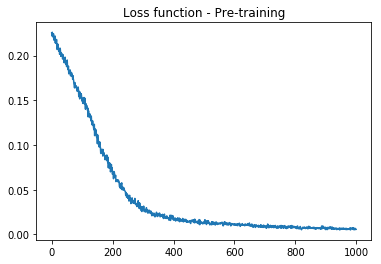

In [10]:
d_pre_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D_pre')
d_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Disc')
g_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Gen')

# set up optimizer for G,D
opt_d=adam_optimizer(obj_d, d_params)
opt_g=adam_optimizer(obj_g, g_params) #

sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

#Pretraining of the discriminator:
M = 1000
lh=np.zeros(M)

for i in range(M):
    z = zPrior.rvs(size = M)
    x = np.reshape(np.repeat(zPost.x,M),(M,1))
    labels=np.reshape(np.repeat(0.5,M),(M,1))
    lh[i],_=sess.run([loss,optimizer], {pre_z_node: z, pre_x_node: x, train_labels: labels})

plt.plot(lh)
plt.title('Loss function - Pre-training')
plt.show()


0.0 1.4382956028 5.1253194809
0.1 1.30886769295 3.60844349861
0.2 1.32156693935 3.57550215721
0.3 1.30859708786 3.5723760128
0.4 1.32840156555 3.32725763321
0.5 1.33193385601 3.54276514053
0.6 1.32907283306 3.35054421425
0.7 1.32335317135 3.45422148705
0.8 1.33357810974 3.44262218475
0.9 1.32099783421 3.45954155922


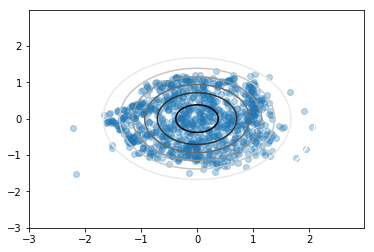

In [12]:
weightsD = sess.run(d_pre_params)

for i, v in enumerate(d_params):
    sess.run(v.assign(weightsD[i]))

# Training Algorithm

k=1 #Times we train the discriminator for each run of the generator.
TRAIN_ITERS = 10000
histd, histg= np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
M=1000

for i in range(TRAIN_ITERS):
    for j in range(k):
        z = zPrior.rvs(size = M) #Sample from prior.
        x = np.reshape(sample([1,10,30], M), (M,1))
        #x = np.reshape(np.repeat(zPost.x,M),(M,1))
        noise = mn(mean = [0,0,0], cov = np.eye(3)).rvs(size = M)
        #noise = np.reshape(mn(mean = [0], cov = np.eye(1)).rvs(size = M), (M,1))
        histd[i],_=sess.run([obj_d, opt_d], {z_node:z, x_node: x,
                            gen_noise_node : noise, gen_x_node : x})
    noise = mn(mean = [0,0,0], cov = np.eye(3)).rvs(size = M)
    #noise = np.reshape(mn(mean = [0], cov = np.eye(1)).rvs(size = M), (M,1))
    histg[i],_ = sess.run([obj_g,opt_g], {gen_noise_node:noise,  gen_x_node: x}) # update generator
    if i % (TRAIN_ITERS//10) == 0:
        print(float(i)/float(TRAIN_ITERS), histd[i], histg[i])

x = 1
plot_fig(x, M = 1000, zmin = -3, zmax = 3, cmap_par = 'Greys')
plt.show()


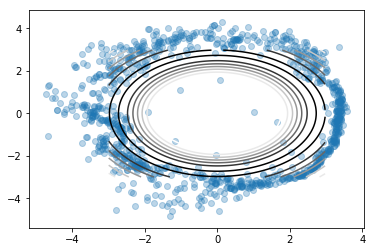

In [13]:
x = 30
plot_fig(x, M = 1000, zmin = -3, zmax = 3, cmap_par = 'Greys')
plt.show()

